In [46]:
# Style cell, select View -> Hide cell from viewers -> Input and hide output
my_css="""

h1 {
    border: 1.5px solid #2968A3;
    padding: 8px 12px;
    border-radius:5px;
    background-image: linear-gradient(180deg, #FFFFFF, rgb(41,104,163)); /* blue */
    position: static;
}

h2 {
    color:white;
    padding: 6px 10px;
    border-radius:4px;
    display:fill;
    background-color:#2968A3;
    position: static;
}

blockquote {
  border: 1px groove gray;
  border-radius: 3px;
  background-color: rgb(255, 253, 208); */ #fffdd0, cream */
}

"""

open('style.css', 'w').write(my_css)
from IPython.core.display import HTML

def css_styling():
    styles = open("./style.css", "r").read()
    return HTML("<style>" + open("style.css", "r").read() + "</style>")
css_styling()

# Introduction

This notebook presents a simple guide to creating an artificial neural network with PyTorch. It will predict the outcome of the hand-written images from the Modified National Institute of Standards and Technology dataset (MNIST).

The guide contains the most elementary PyTorch elements to create and evaluate a network.


In [47]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader # loads data in batches
from torchvision import datasets # load MNIST
import torchvision.transforms as T # transformers for computer vision

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

# Torchvision datasets

We obtain the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) via torchvision. The dataset contains 60,000 records (images), each having 784 incoming features (28 x 28 pixels). Note that `datasets` is an object imported from torchvision, not to confuse with from the Dataset object (used in torch.utils.data import Dataset)

```from torchvision import datasets```

When called for the first time, the datasets will be downloaded to the path specified in the `root` argument. After that, Torchvision will look first for a local copy before attempting another download.

> **torchvision.transforms**. A transformer operates on the data. Using the ' transform' argument, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the data obtained.

In [49]:
mytransform = T.ToTensor() # image (3D array) to Tensor

train_data = datasets.MNIST(root = './', download=True, train = True, transform = mytransform)
test_data = datasets.MNIST(root = './', download=True, train = False, transform = mytransform)

Note that the first image in the dataset is a 3D tensor (C, H, W) for the number of channels (C), Height (H), and Width (W).

In [50]:
img, label = train_data[0]
img.shape # returns a Tensor of Size 1,28,28

torch.Size([1, 28, 28])

We plot the first image if we reshape the image into a 2D array (HxW).

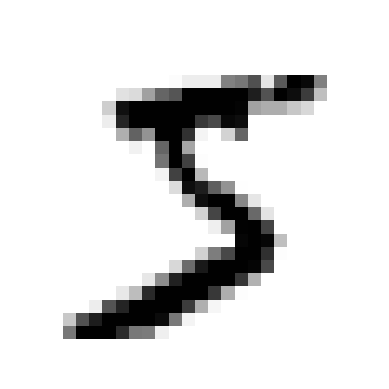

In [51]:
# We could simply plot the tensor
plt.imshow(img.reshape(28,28), cmap = 'gist_yarg'); # gist_yarg plots inverse of W&B
plt.axis('off');

# DataLoader

The PyTorch DataLoader object allows the preparation of the dataset in batches of different sizes and shuffles them if necessary when exposing them to the training.

```from torch.utils.data import DataLoader```

> Note that the DataLoader object shuffles the data by default.

In [52]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size = 100, shuffle=True)
# the test loader can be bigger and doesn't need to be shuffled
test_loader =  DataLoader(test_data,  batch_size = 500, shuffle=False)

I like using a dummy class definition called `Loader` to access both the train and the test loaders. Of course, I could employ a dictionary, but I think a class it's easier to define.

In [53]:
from dataclasses import dataclass

@dataclass
class Loader:
    """
    Custom class to accomodate train and test loader iterators
    """
    train: DataLoader  # train DataLoader iterable object
    test:  DataLoader  # test DataLoader iterable object

myloader = Loader(train = train_loader, test = test_loader)
print(myloader)

Loader(train=<torch.utils.data.dataloader.DataLoader object at 0x7cc8dc4762d0>, test=<torch.utils.data.dataloader.DataLoader object at 0x7cc8dc2f6420>)


If we run one iteration now, we will have one batch of the training dataset (100 images and labels).

In [54]:
# Plot 10 images
for img, label in myloader.train:
    break # we run only one iteration , after that we break
img.shape # bz, ch, W H

torch.Size([100, 1, 28, 28])

Let's select the 50 first images of the batch to plot them.

In [55]:
myimages = img[:50].numpy() # we now obtain NumPy arrays
myimages.shape

(50, 1, 28, 28)

We will need to transpose the NumPy array to plot it with matplotlib (accepts height x width matrices).

In [56]:
myimages[0].shape # channel, height, width

(1, 28, 28)

In [57]:
myimages[0].transpose(1,2,0).shape # height, width, channel

(28, 28, 1)

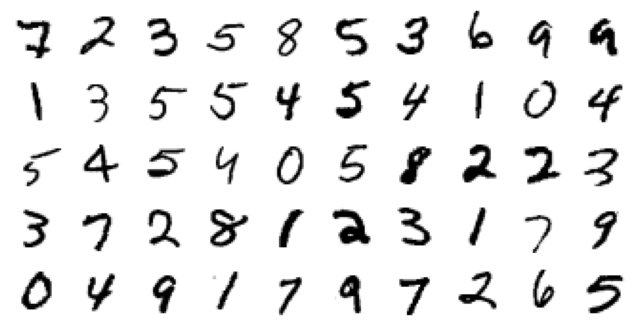

In [58]:
fig, ax = plt.subplots(nrows = 5, ncols = 10, figsize=(8,4), subplot_kw={'xticks': [], 'yticks': []})
for row in range(0,5):
    for col in range(0,10):
        myid = (10*row) + col # (ncols*rows) + cols

        ax[row,col].imshow( myimages[myid].transpose(1,2,0), cmap = 'gist_yarg' ) # W,H,C
        ax[row,col].axis('off')

# Create the network

The training set contains 60,000 records with 784 incoming features. The first layer is 784 neurons. After that, we create two fully connected layers of 120 and 84 neurons, respectively. The activation function we use is a Rectified Linear Unit (ReLU) function. This piecewise function that makes negative inputs to the neuron will be zero and scales up to positive ones.

Finally, the output layer contains ten layers. Every layer is the probability of having the label given (from 1 to 10), with the condition that the sum of the probabilities is one (Log softmax).

In [59]:
class MultilayerPerceptron(nn.Module):
    """
    A simple multilayer perceptron network

    """
    def __init__(self, in_features = 784, out_features=10):
        """
        * 784 input layers
        * 2 hiden layers of 120 and 84 neurons respectively
        * 10 output layer
        """
        super(MultilayerPerceptron, self).__init__()

        self.fc1 = nn.Linear(in_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_features)

    def forward(self, X):

        X = F.relu(self.fc1(X)) # Rectified Linear Unit (ReLU)
        X = F.relu(self.fc2(X)) # Rectified Linear Unit (ReLU)
        X = self.fc3(X)

        return F.log_softmax(X, dim = 1) # multi-class classification, the sum of all probabilities is 1

In [60]:
torch.manual_seed(101)

mymodel = MultilayerPerceptron() # default params are in_features = 784, out_features=10
mymodel # check topology

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

* We select the [cross-entroy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=entropy) as the cost function. The cross-entropy is similar to the quadratic formula, but it predicts the probability distribution of each class.

* We define the optimization method. The simplest one is the [Adaptative Stochastic Gradient Descent method](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [61]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mymodel.parameters(), lr = 1e-3)

How many parameters do we need to evaluate?

* Number of weights = (784 x 120) + (120 x 84) + (84 x 10) = 105,000
* Number of biases = 120 + 84 + 10 = 214

Total = 105,214

In [62]:
params = [p.numel() for p in mymodel.parameters() if p.requires_grad]
np.sum(params)

np.int64(105214)

# Training and evaluation

1. Before starting, we must consider that the DataLoader returns a tensor of size [100,1,28,28], but our model accepts 1D vectors of 784 pixels (28x28). Therefore, we must flatten the tensor to accommodate the model's input.

In [63]:
# Plot 10 images
myiter = iter(myloader.train)
img, label = next(myiter) # only one iteration
img.shape # batch_size, channel, Height, Width

torch.Size([100, 1, 28, 28])

2. We will flatten the dimensions of the batch (1,28,28) that correspond to channel, height, and width. That's a common preprocessing step when using images to allocate a 1D vector to the entry of the network (in our case, a 28 x 28 = 784 vector).

In [64]:
img.view(100,-1).shape # 100 batches of 784 pixels

torch.Size([100, 784])

Let's evaluate that batch without training the model. The prediction returns a 100 x 10 tensor. It means that we obtain ten probabilities for every batch of 100 images (shape is [100,10]).

In [65]:
y_pred = mymodel( img.view(100,-1) )
y_pred.shape # 100 x 10, meaning for every batch (100) we obtain  (10 probabilities) predictions

torch.Size([100, 10])

If we calculate the index with the highest probability for every label outcome, we obtain:

In [66]:
val, idx = torch.max(y_pred, dim=1) # dim 1 is for the output
idx # indices == predictions

tensor([2, 2, 2, 2, 8, 2, 2, 8, 2, 6, 8, 8, 8, 8, 8, 8, 8, 2, 6, 2, 8, 2, 2, 2,
        8, 2, 6, 8, 6, 2, 6, 8, 2, 2, 8, 7, 6, 6, 2, 2, 2, 8, 2, 2, 6, 6, 8, 8,
        8, 2, 2, 7, 8, 6, 2, 8, 2, 2, 2, 6, 2, 2, 2, 6, 7, 2, 8, 8, 6, 6, 2, 8,
        2, 6, 7, 8, 6, 8, 6, 2, 2, 2, 2, 2, 2, 6, 8, 8, 2, 8, 6, 2, 2, 6, 2, 2,
        8, 8, 2, 2])

3. We will calculate the model's accuracy in every epoch (number of correct projections in/batch size) for both the train and the test dataset.

In [67]:
# tracking variables

class Loss:
    """ Class to monitor train and test lost"""
    train: list = []
    test: list = []


class Accuracy:
    """ Class to monitor train and test accuracy"""
    train: list = []
    test: list = []

In [68]:
%%time

epochs = 10
for epoch in tqdm(range(epochs)):
    # we set the number of True positives to zero in every epoch
    train_corr = 0
    test_corr = 0

    # training: we run the train dataset in batches of 100 images, meaning that run the loader 600 times (600 x 100 = 60,000 images)
    for batch, (img, label) in enumerate(myloader.train):
        batch +=1
        y_pred = mymodel( img.view(100,-1) ) # batch size for train is 100
        loss = criterion(y_pred, label)

        # last 10-layer neurons into one result
        _, prediction = torch.max(y_pred,dim = 1)
        train_corr += (prediction == label).sum() # sum of correct predictions


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # monitor loss and accuracy every 200 train batches of 100 images ( 3 times per epoch)
        if batch%200 == 0:
            acc = 100 * (train_corr.item() / (batch*100) ) # correct predictions divided by images in batches
            print( f'Epoch:{epoch:2d} batch: {batch:2d} loss: {loss.item():4.4f} Accuracy: {acc:4.4f} %' )

    Loss.train.append( loss.item() ) # store loss at the end of epoch
    accuracy = 100 * (train_corr.item() / (batch*100) ) # accuracy is 100 x train_corr.item()/60_000
    Accuracy.train.append( accuracy ) # store accuracy at the end of epoch


    # validation (test). Here we run batches of 500 images, the test loader runs 120 times (120 x 500 = 60,000)
    with torch.no_grad():
        for batch, (img, label) in enumerate(myloader.test):
            batch +=1
            y_val = mymodel( img.view(500,-1) ) # batch size for test is 500
            _, predicted = torch.max( y_val, dim = 1)
            test_corr += (predicted == label).sum()

    loss = criterion( y_val,label )
    Loss.test.append( loss.item() )
    accuracy = 100 * (test_corr.item()/ (batch*500) ) # accuracy is 100 x train_corr.item()/60,000
    Accuracy.test.append( accuracy )


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 batch: 200 loss: 0.2996 Accuracy: 82.6550 %
Epoch: 0 batch: 400 loss: 0.2726 Accuracy: 87.2475 %
Epoch: 0 batch: 600 loss: 0.1816 Accuracy: 89.3167 %


 10%|█         | 1/10 [00:09<01:23,  9.30s/it]

Epoch: 1 batch: 200 loss: 0.1717 Accuracy: 94.6250 %
Epoch: 1 batch: 400 loss: 0.0496 Accuracy: 95.0125 %
Epoch: 1 batch: 600 loss: 0.1437 Accuracy: 95.2567 %


 20%|██        | 2/10 [00:18<01:14,  9.34s/it]

Epoch: 2 batch: 200 loss: 0.1706 Accuracy: 96.5700 %
Epoch: 2 batch: 400 loss: 0.1689 Accuracy: 96.5400 %
Epoch: 2 batch: 600 loss: 0.1113 Accuracy: 96.6200 %


 30%|███       | 3/10 [00:27<01:04,  9.20s/it]

Epoch: 3 batch: 200 loss: 0.1434 Accuracy: 97.4550 %
Epoch: 3 batch: 400 loss: 0.0125 Accuracy: 97.4975 %
Epoch: 3 batch: 600 loss: 0.0761 Accuracy: 97.4100 %


 40%|████      | 4/10 [00:36<00:54,  9.01s/it]

Epoch: 4 batch: 200 loss: 0.0562 Accuracy: 97.9850 %
Epoch: 4 batch: 400 loss: 0.1052 Accuracy: 97.9050 %
Epoch: 4 batch: 600 loss: 0.0946 Accuracy: 97.9417 %


 50%|█████     | 5/10 [00:45<00:45,  9.14s/it]

Epoch: 5 batch: 200 loss: 0.0782 Accuracy: 98.4950 %
Epoch: 5 batch: 400 loss: 0.0238 Accuracy: 98.4025 %
Epoch: 5 batch: 600 loss: 0.0412 Accuracy: 98.3367 %


 60%|██████    | 6/10 [00:55<00:37,  9.33s/it]

Epoch: 6 batch: 200 loss: 0.0220 Accuracy: 98.8100 %
Epoch: 6 batch: 400 loss: 0.0414 Accuracy: 98.6775 %
Epoch: 6 batch: 600 loss: 0.0283 Accuracy: 98.6617 %


 70%|███████   | 7/10 [01:04<00:27,  9.29s/it]

Epoch: 7 batch: 200 loss: 0.0041 Accuracy: 99.0500 %
Epoch: 7 batch: 400 loss: 0.0084 Accuracy: 98.9250 %
Epoch: 7 batch: 600 loss: 0.0285 Accuracy: 98.8583 %


 80%|████████  | 8/10 [01:13<00:18,  9.27s/it]

Epoch: 8 batch: 200 loss: 0.0076 Accuracy: 99.1900 %
Epoch: 8 batch: 400 loss: 0.0840 Accuracy: 99.1550 %
Epoch: 8 batch: 600 loss: 0.0532 Accuracy: 99.1117 %


 90%|█████████ | 9/10 [01:22<00:09,  9.09s/it]

Epoch: 9 batch: 200 loss: 0.0391 Accuracy: 99.3550 %
Epoch: 9 batch: 400 loss: 0.0598 Accuracy: 99.3225 %
Epoch: 9 batch: 600 loss: 0.0201 Accuracy: 99.2250 %


100%|██████████| 10/10 [01:31<00:00,  9.17s/it]

CPU times: user 1min 30s, sys: 88.7 ms, total: 1min 30s
Wall time: 1min 31s


# Visualization

We'll see train and test losses, together with its accuracies per epoch. Note that the training data have more minor losses and reach an accuracy of almost 100%. On the other hand, the test data reach almost a plateau of > 95% accuracy, and we could think of using more than two epochs because this is where the training data crosses the accuracy of the testing data.

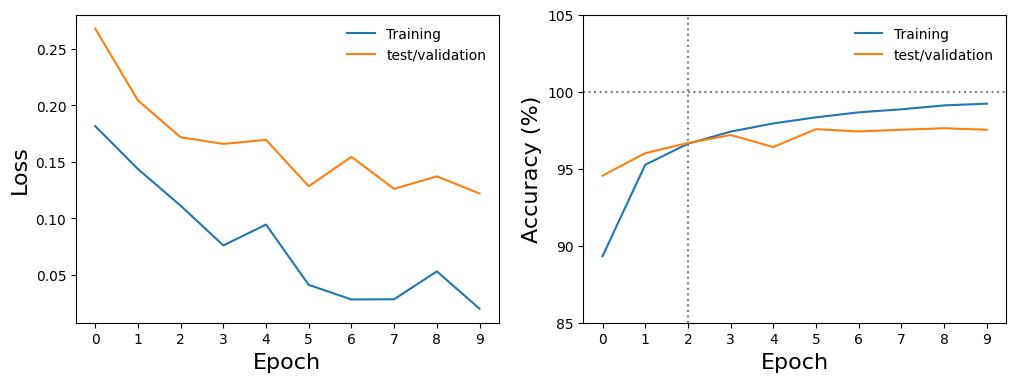

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(Loss.train, label = 'Training')
ax[0].plot(Loss.test, label='test/validation')
ax[0].set_ylabel('Loss', fontsize=16)


ax[1].plot(Accuracy.train, label = 'Training')
ax[1].plot(Accuracy.test, label='test/validation')
ax[1].set_yticks(range(85,110,5))
ax[1].axvline(x=2, color='gray', linestyle=':')
ax[1].axhline(y=100, color='gray', linestyle=':')
ax[1].set_ylabel('Accuracy (%)', fontsize=16)

for myax in ax:
    myax.set_xlabel('Epoch', fontsize=16)
    myax.set_xticks(range(epochs))
    myax.legend(frameon=False)



Finally, we evaluate all the test data at once and visualize the accuracy of every outcome for every prediction (i.e., confusion matrix).

In [70]:
test_loader =  DataLoader(test_data,  batch_size = 10_000, shuffle=False) # the whole test is 10,000 images
myiter = iter(test_loader)
img, label = next(myiter)
img.shape

torch.Size([10000, 1, 28, 28])

In [71]:
with torch.no_grad():
    correct = 0

    for X, y_label in test_loader:
            y_val = mymodel( X.view(X.shape[0],-1) ) # flatten
            _, predicted = torch.max( y_val, dim = 1)
            correct += (predicted == y_label).sum()

print(f'Test accuracy: = {correct.item()*100/(len(test_data)):2.4f} %')

Test accuracy: = 97.5300 %


In [72]:
from sklearn.metrics import confusion_matrix  # for evaluating results
confusion_array = confusion_matrix(y_true = y_label,y_pred = predicted)
confusion_array

array([[ 969,    0,    3,    0,    0,    0,    4,    0,    2,    2],
       [   0, 1121,    4,    2,    0,    0,    2,    0,    6,    0],
       [   1,    0, 1022,    2,    0,    0,    2,    2,    2,    1],
       [   1,    0,   12,  980,    0,    2,    1,    2,   10,    2],
       [   0,    0,    8,    0,  950,    0,    8,    3,    2,   11],
       [   1,    0,    0,   12,    1,  858,   10,    0,    9,    1],
       [   2,    3,    3,    1,    1,    2,  944,    0,    2,    0],
       [   1,    6,   13,    3,    1,    0,    0,  993,    5,    6],
       [   3,    0,    4,    2,    1,    2,    4,    2,  954,    2],
       [   4,    2,    0,   10,    9,    6,    1,    3,   12,  962]])

<Axes: >

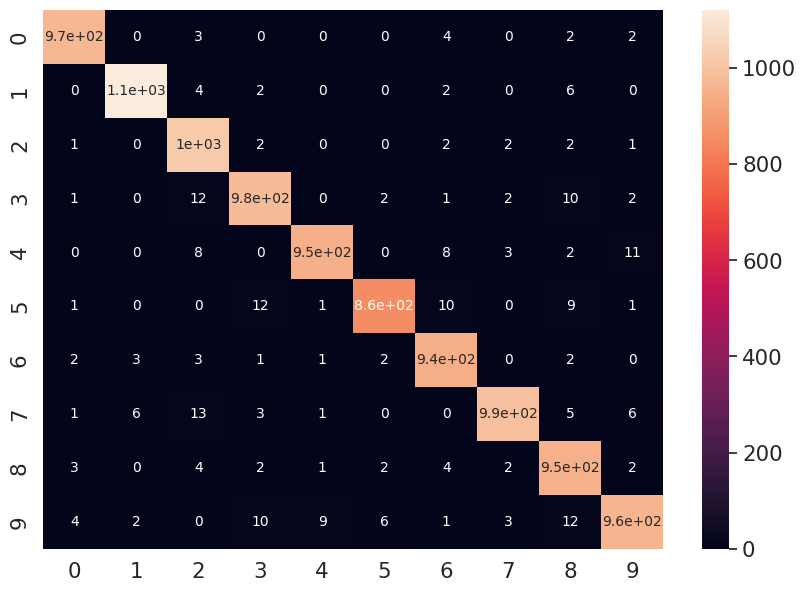

In [73]:
import pandas as pd
import seaborn as sn
df_cm = pd.DataFrame(confusion_array, range(10), range(10))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size



In [77]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('test_image.jpg', target_size=(28, 28), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = mymodel(torch.from_numpy(img_array).float().view(1,-1))
predicted_class = torch.argmax(prediction).item()
print("Tahmin edilen rakam:", predicted_class)

Tahmin edilen rakam: 3


In [79]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import torch

all_y_true = []
all_y_pred = []

# Ensure the model is in evaluation mode
mymodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        # Flatten images for the model
        images = images.view(images.shape[0], -1)

        # Get predictions
        outputs = mymodel(images)
        _, predicted = torch.max(outputs.data, 1)

        # Collect true and predicted labels
        all_y_true.extend(labels.cpu().numpy())
        all_y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
acc = accuracy_score(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred, average='macro')
conf_matrix = confusion_matrix(all_y_true, all_y_pred)

print(f"Doğruluk (Accuracy): {acc:.4f}")
print(f"F1 Skoru: {f1:.4f}")
# print("Confusion Matrix:")
# print(conf_matrix)

Doğruluk (Accuracy): 0.9753
F1 Skoru: 0.9751


Hangi Ölçüt Daha Önemli?
En uygun ölçüt: F1 Skoru

Çünkü:
El yazısı tanıma problemi çok sınıflı ve dengesiz olabilir (örneğin bazı rakamlar daha zor tanınır).

Accuracy (doğruluk) sadece genel başarıyı gösterir, ancak bazı rakamların çok iyi, bazılarının kötü tanındığını gizleyebilir.

F1 skoru ise hassasiyet (precision) ve duyarlılığı (recall) birlikte değerlendirir.

Bu yüzden sınıflar arası dengesizlik varsa F1, gerçek performansı daha doğru yansıtır.

Eğer veri kümesi her sınıf için dengeliyse, accuracy de anlamlı bir ölçüttür.